In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def calculate_profit(ticker , from_date , to_date):
    filename = ('stocks/{0}.csv').format(ticker)
    data = pd.read_csv(filename)
    data = data.loc[ (data['Date'] >= from_date) & (data['Date'] <= to_date)]
    change_Percent  =  (data.iloc[-1]['Adj Close'] -  data.iloc[0]['Adj Close']) * 100 /  data.iloc[0]['Adj Close']
    print(ticker, np.round(change_Percent,3))
    

In [3]:
corr_df = pd.read_csv('symbols-correlation.csv', index_col='Symbol')
symbols  = corr_df.index
corr_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Symbol,,,,,,,,,,,,,,,,,,,,,
A,0,50,24,88,72,48,52,88,100,76,...,62,74,46,68,70,24,70,76,60,78
AAL,50,0,42,60,56,26,18,36,40,48,...,56,76,2,76,60,-6,38,32,74,38
AAP,24,42,0,46,62,12,16,20,36,22,...,36,48,28,70,60,8,24,22,48,22
AAPL,88,60,46,0,48,8,40,68,82,54,...,74,80,14,78,68,34,60,72,50,58
ABBV,72,56,62,48,0,50,84,78,94,54,...,26,58,48,62,56,16,58,44,68,56


In [4]:
def index_data (symbols, df):

    symbols_dic = {symbols[i]: i for i in range(len(symbols))}
    df_records = df.copy()
    mix_sim = df_records['Symbol_1'] + '_' + df_records['Symbol_2']
    
    df_records.insert(0, "Symbol", mix_sim) 
     
    cleanup_nums = {
    "Symbol_1": symbols_dic,
    "Symbol_2": symbols_dic
    }

    df_records.replace(cleanup_nums, inplace=True)
    df_records = df_records.set_index('Symbol')
    return df_records

In [5]:
df = corr_df.where(np.tril(np.ones(corr_df.shape) , k = -1).astype(np.bool))
df = df.stack().reset_index()
df.columns =['Symbol_1', 'Symbol_2','Correlation']
df = index_data(symbols, df)
df.head()

,Symbol_1,Symbol_2,Correlation
Symbol,,,
AAL_A,1,0,50.0
AAP_A,2,0,24.0
AAP_AAL,2,1,42.0
AAPL_A,3,0,88.0
AAPL_AAL,3,1,60.0


In [6]:
def convert_to_univariate_series(df):
    
    mix_symbols = df.index
    X = df.to_numpy()
        
    pca = PCA(n_components=2)
    new_X = pca.fit_transform(X)

    new_df = pd.DataFrame(new_X, index= mix_symbols)
    return new_df

In [7]:
def k_mean_clustering(data):
   # define normalizer
    normalizer = Normalizer()

    # create a K-means model with n clusters
    kmeans = KMeans(n_clusters=10, max_iter=1000 , n_init = 50)

    # make a pipeline chaining normalizer and kmeans
    pipeline = make_pipeline(normalizer,kmeans) 
    
    pipeline.fit(data)
    
    # predict cluster labels
    labels = pipeline.predict(data)
    
    return labels

In [8]:
univariate_df = convert_to_univariate_series(df)
mix_symbols = univariate_df.index.to_numpy()
data = univariate_df.to_numpy()

clusters = k_mean_clustering(data)

NameError: name 'labels' is not defined

In [9]:
# create a DataFrame aligning labels & companies
df_result = pd.DataFrame({'Cluster': clusters, 'Symbol': mix_symbols})

# display df sorted by cluster labels
df_result = df_result.sort_values('Cluster')
df_result.head()

,Cluster,Symbol
93117,0,TMUS_AIZ
102380,0,USB_AAP
102379,0,USB_AAL
102378,0,USB_A
64409,0,PFG_ECL


In [10]:
def clusters_symbols ( symbols, df_result):
    
    cluster_index = []
    for symbol in symbols :
        found_cluster =  df_result[df_result['Symbol'].str.contains(symbol +"_")].groupby('Cluster').count().reset_index()
        cluster = found_cluster.nlargest(1 ,'Symbol')['Cluster'].values[0]
        cluster_index.append(cluster)
        
    return cluster_index
        

In [13]:
index = clusters_symbols(symbols, df_result)

# create a DataFrame aligning labels & companies
df_mean = pd.DataFrame({'Cluster': index, 'Symbol': symbols})

# display df sorted by cluster labels
df_mean = df_mean.sort_values('Cluster')
df_mean.head()

,Cluster,Symbol
0,2,A
390,2,RL
391,2,RMD
392,2,ROK
393,2,ROL


In [16]:
def plot_cluster(df, cluster_df , cluster_number = 0):
    
    cluster_list =  cluster_df[cluster_df['Cluster'] == cluster_number]['Symbol'].tolist()

    sns.set(rc={'figure.figsize':(16, 16)})
    
    cluster_Symbol = pd.DataFrame()
    for s in cluster_list[:5]: 
        cluster_Symbol[s] = df.loc[s]

    cluster_Symbol.plot(subplots=True, legend=False)
    plt.show()



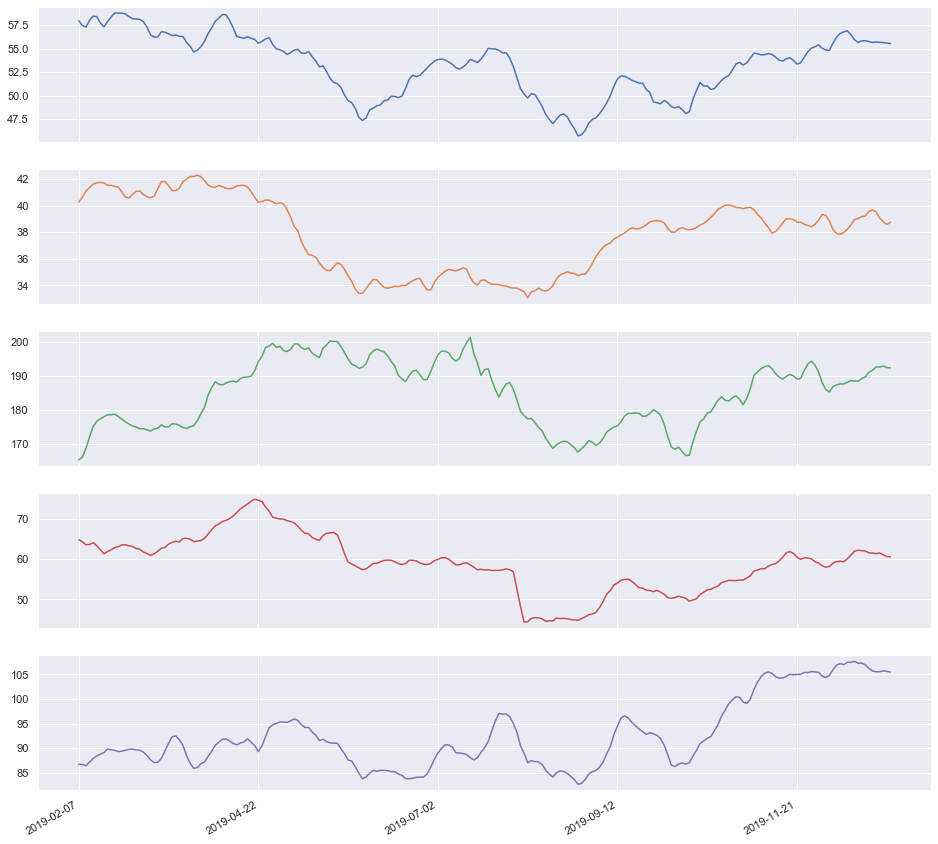

In [19]:
df_ = pd.read_csv('stocks/total_data_price_Symbol.csv', index_col='Symbol')
plot_cluster(df_, df_mean,5)

In [22]:
set(index)

{2, 3, 5, 7, 9}